In [76]:
# import necessary libraries
import pandas as pd
import numpy as np
import re
import gensim.downloader as api

import spacy
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from collections import defaultdict
from sklearn.manifold import TSNE
import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.pyplot as plt

In [77]:
# Uncomment if necessary
# pip install wordcloud
# pip install sentence_transformers

In [78]:
# import preproccessed csv file
df = pd.read_csv('preprocessed_amazon.csv')

In [79]:
# Tokenization and Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['Product Description'])

In [80]:
# Tokenization and Vectorization using Word2Vec
tokenized_text = [word_tokenize(text) for text in df['Product Description']]
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, sg=0)

In [81]:
# Averaging Word2Vec vectors for each tokenized description
X_word2vec = []
for text in tokenized_text:
    vectors = [word2vec_model.wv[word] for word in text if word in word2vec_model.wv]
    if vectors:
        X_word2vec.append(np.mean(vectors, axis=0))
    else:
        X_word2vec.append(np.zeros(word2vec_model.vector_size))  # Use zero vector if no valid words found

X_word2vec = np.array(X_word2vec)

In [82]:
# Fit the KNN model using TF-IDF vectors
knn_tfidf = NearestNeighbors(n_neighbors=15, metric='cosine')
knn_tfidf.fit(X_tfidf)

# Fit the KNN model using Word2Vec vectors
knn_word2vec = NearestNeighbors(n_neighbors=15, metric='cosine')
knn_word2vec.fit(X_word2vec)

NearestNeighbors(metric='cosine', n_neighbors=15)

In [83]:
def find_similar_posts(input_text, vectorizer, knn_model, top_k=5):
    if vectorizer == 'tfidf':
        input_vector = tfidf_vectorizer.transform([input_text])
    elif vectorizer == 'word2vec':
        words = word_tokenize(input_text)
        word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
        if len(word_vectors) == 0:
            return []
        input_vector = np.mean(word_vectors, axis=0).reshape(1, -1)
    
    if vectorizer == 'tfidf':
        _, indices = knn_tfidf.kneighbors(input_vector, n_neighbors=top_k)
    elif vectorizer == 'word2vec':
        _, indices = knn_word2vec.kneighbors(input_vector, n_neighbors=top_k)
    
    return df.iloc[indices[0]]['Product Title'].tolist()

# Test
input_text = "purple phonecase"
similar_posts_tfidf = find_similar_posts(input_text, 'tfidf', knn_tfidf)
similar_posts_word2vec = find_similar_posts(input_text, 'word2vec', knn_word2vec)

print("Similar posts using TF-IDF:")
for idx, post in enumerate(similar_posts_tfidf, start=1):
    print(f"{idx}. {post}")
    
print("\nSimilar posts using Word2Vec:")
for idx, post in enumerate(similar_posts_word2vec, start=1):
    print(f"{idx}. {post}")

Similar posts using TF-IDF:
1.  Tootsie Rolls Frooties Grape Candy (360 Count), 38.8Oz 
2.  Tec Italy - Lumina Purple Conditioner 
3.  Storeway Nike Basic Purple EDT Deodorant Body Spray for Women 200ml 
4.  60ml , purple : MSmask Travel Bottle Squeezing Bath Lotion Cosmetic Skincare Refillable None Leaking 
5.  Purple : ecoLove Purple Collection Conditioner for colored and very dry hair - Blueberry, Grape & Lavender. 100% VEGAN (17.6 Oz) 

Similar posts using Word2Vec:
1.  Generic orange black white, Adult small : digital camo Arm Sleeve UV Sunscreen Sports Elbow baseball stitch softball stitch Elbow Support Quick Dry Basketball Arm Warmer 
2.  Genuine Kart White Peel Off Nail Liquid Art Latex Tape Easy To Clean Nail Polish Finger Skin Protected Liquid Palisade Base Coat Care 6Ml 
3.  Generic pink black white, Adult Xlarge : digital camo Arm Sleeve UV Sunscreen Sports Elbow baseball stitch softball stitch Elbow Support Quick Dry Basketball Arm Warmer 
4.  Fashlady Gray: 12 PCS Waterpr

In [84]:
glove_model = api.load('glove-wiki-gigaword-100')

# Fit the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['Product Description'])

# Fit the KNN model using TF-IDF vectors
knn_tfidf = NearestNeighbors(n_neighbors=15, metric='cosine')
knn_tfidf.fit(X_tfidf)

# Fit the KNN model using GloVe vectors
def get_glove_vector(word):
    try:
        return glove_model[word]
    except KeyError:
        return None

def get_mean_glove_vectors(words):
    vectors = [get_glove_vector(word) for word in words]
    vectors = [vec for vec in vectors if vec is not None]
    if len(vectors) == 0:
        return None
    return np.mean(vectors, axis=0).reshape(1, -1)

def get_glove_vectorized_data(X):
    vectors = [get_mean_glove_vectors(word_tokenize(str(text))) for text in X['Product Title']]
    valid_vectors = [vec for vec in vectors if vec is not None]
    return np.concatenate(valid_vectors) if valid_vectors else np.array([])

X_glove_array = get_glove_vectorized_data(df)
knn_glove = NearestNeighbors(n_neighbors=15, metric='cosine')
knn_glove.fit(X_glove_array)

def find_similar_posts(input_text, vectorizer, knn_model, top_k=5):
    if vectorizer == 'tfidf':
        input_vector = tfidf_vectorizer.transform([input_text])
    elif vectorizer == 'glove':
        input_vector = get_mean_glove_vectors(word_tokenize(input_text))
        if input_vector is None:
            return []
    
    if vectorizer == 'tfidf':
        _, indices = knn_tfidf.kneighbors(input_vector)
    elif vectorizer == 'glove':
        _, indices = knn_glove.kneighbors(input_vector)
    
    return df.iloc[indices[0]]['Product Title']

# Test
input_text = "purple phonecase"
similar_posts_tfidf = find_similar_posts(input_text, 'tfidf', knn_tfidf)
similar_posts_glove = find_similar_posts(input_text, 'glove', knn_glove)

print("Similar posts using TF-IDF:")
print(similar_posts_tfidf)
print("\nSimilar posts using GloVe:")
print(similar_posts_glove)


Similar posts using TF-IDF:
13952     Tootsie Rolls Frooties Grape Candy (360 Count...
7987                Tec Italy - Lumina Purple Conditioner 
2548      Storeway Nike Basic Purple EDT Deodorant Body...
5093      60ml , purple : MSmask Travel Bottle Squeezin...
15091     Purple : ecoLove Purple Collection Conditione...
11987     stephblack Simple Bathing Strap with Exfoliat...
10601     Avon Little Gold Dress Combo (EDP + Skin Soft...
364       Reiko Flexible Long Arms Hand Free Phone Holder 
14215     ddp acrylic nail pincher tool multi function ...
2369      Fashlady™ Green: Elecool 1 Pair Spa Gel Socks...
4471      Lili DIY Nails Rhinestone 3D Acrylic Crystal ...
6781      Ubervia Pack of 1 100g Multicolor Bath Ball H...
6407      Bombshell By Victorias Secret For Women Body ...
10195     Generic Purple, L : Yel 2 pcs Top Basketball ...
7825      Generic Pink: pro Makeup Candy Color Moisturi...
Name: Product Title, dtype: object

Similar posts using GloVe:
13930     Suave Invis Sl

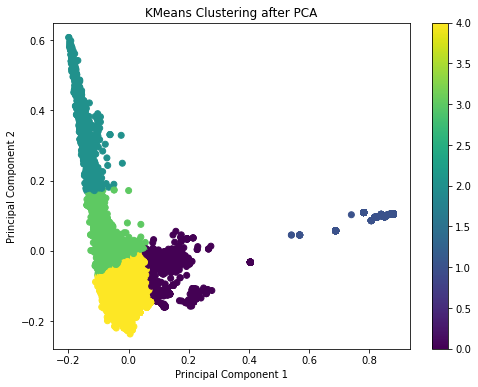

In [85]:
# Reduce dimensions using IncrementalPCA
n_components = 2
batch_size = 1000
n_batches = int(np.ceil(X_tfidf.shape[0] / batch_size))

ipca = IncrementalPCA(n_components=n_components)
for i in range(n_batches):
    start = i * batch_size
    end = (i + 1) * batch_size
    X_batch = X_tfidf[start:end]
    ipca.partial_fit(X_batch.toarray())

X_pca = ipca.transform(X_tfidf.toarray())  

# Perform KMeans clustering
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
kmeans.fit(X_pca)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('KMeans Clustering after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()


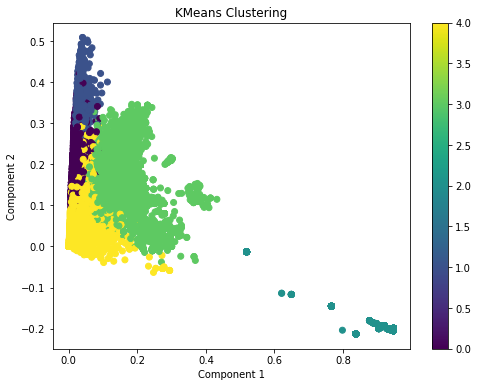

Similar posts using TF-IDF:
13952     Tootsie Rolls Frooties Grape Candy (360 Count...
7987                Tec Italy - Lumina Purple Conditioner 
2548      Storeway Nike Basic Purple EDT Deodorant Body...
5093      60ml , purple : MSmask Travel Bottle Squeezin...
15091     Purple : ecoLove Purple Collection Conditione...
11987     stephblack Simple Bathing Strap with Exfoliat...
10601     Avon Little Gold Dress Combo (EDP + Skin Soft...
364       Reiko Flexible Long Arms Hand Free Phone Holder 
14215     ddp acrylic nail pincher tool multi function ...
2369      Fashlady™ Green: Elecool 1 Pair Spa Gel Socks...
4471      Lili DIY Nails Rhinestone 3D Acrylic Crystal ...
6781      Ubervia Pack of 1 100g Multicolor Bath Ball H...
6407      Bombshell By Victorias Secret For Women Body ...
10195     Generic Purple, L : Yel 2 pcs Top Basketball ...
7825      Generic Pink: pro Makeup Candy Color Moisturi...
Name: Product Title, dtype: object

Similar posts using GloVe:
1672      Sinland Makeup

In [90]:
glove_model = api.load('glove-wiki-gigaword-100')

def get_glove_vector(word):
    try:
        return glove_model[word]
    except KeyError:
        return None

def get_mean_glove_vectors(words):
    vectors = [get_glove_vector(word) for word in words]
    vectors = [vec for vec in vectors if vec is not None]
    if len(vectors) == 0:
        return np.zeros((1, 100))  # Assuming GloVe vectors are of length 100
    return np.mean(vectors, axis=0).reshape(1, -1)

X_glove = np.concatenate([get_mean_glove_vectors(word_tokenize(str(text))) for text in df['Product Description']])
knn_glove = NearestNeighbors(n_neighbors=15, metric='cosine')
knn_glove.fit(X_glove)

# Perform KMeans++ clustering
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
kmeans.fit(X_tfidf)

# Visualize the clusters
svd = TruncatedSVD(n_components=3, random_state=340)
X_svd = svd.fit_transform(X_tfidf)
plt.figure(figsize=(8, 6))
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('KMeans Clustering')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()
plt.show()

# Define a function to find similar posts using TF-IDF
def find_similar_posts_tfidf(input_text, top_k=15):
    input_vector = tfidf_vectorizer.transform([input_text])
    _, indices = knn_tfidf.kneighbors(input_vector)
    return df.iloc[indices[0]]['Product Title']

# Define a function to find similar posts using GloVe
def find_similar_posts_glove(input_text, top_k=15):
    input_vector = get_mean_glove_vectors(word_tokenize(input_text))
    if input_vector is None:
        return []
    _, indices = knn_glove.kneighbors(input_vector)
    return df.iloc[indices[0]]['Product Title']

# Example usage
input_text = "purple phonecase"
similar_posts_tfidf = find_similar_posts_tfidf(input_text)
similar_posts_glove = find_similar_posts_glove(input_text)

print("Similar posts using TF-IDF:")
print(similar_posts_tfidf)
print("\nSimilar posts using GloVe:")
print(similar_posts_glove)

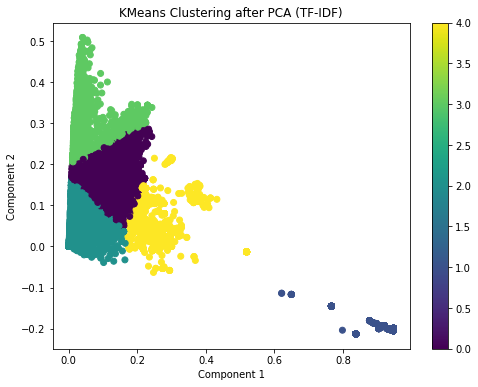

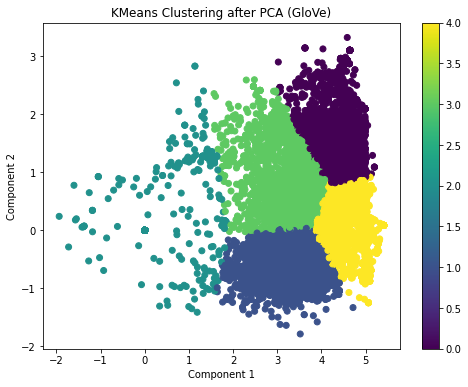

In [91]:
# Perform PCA on TF-IDF vectors
pca = TruncatedSVD(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf)

# Perform PCA on GloVe vectors
X_glove_pca = pca.fit_transform(X_glove)

# Perform KMeans clustering on PCA-transformed TF-IDF vectors
kmeans_pca = KMeans(n_clusters=5, init='k-means++', random_state=42)
kmeans_pca.fit(X_pca)

# Perform KMeans clustering on PCA-transformed GloVe vectors
kmeans_glove_pca = KMeans(n_clusters=5, init='k-means++', random_state=42)
kmeans_glove_pca.fit(X_glove_pca)

# Visualize the clusters for PCA-transformed TF-IDF vectors
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_pca.labels_, cmap='viridis')
plt.title('KMeans Clustering after PCA (TF-IDF)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()
plt.show()

# Visualize the clusters for PCA-transformed GloVe vectors
plt.figure(figsize=(8, 6))
plt.scatter(X_glove_pca[:, 0], X_glove_pca[:, 1], c=kmeans_glove_pca.labels_, cmap='viridis')
plt.title('KMeans Clustering after PCA (GloVe)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()
plt.show()

In [92]:
# Fit the TruncatedSVD (PCA) model
pca = TruncatedSVD(n_components=100, random_state=42)
X_tfidf_pca = pca.fit_transform(X_tfidf)

# Fit the KNN model on the PCA-transformed TF-IDF vectors
knn_tfidf_pca = NearestNeighbors(n_neighbors=15, metric='cosine')
knn_tfidf_pca.fit(X_tfidf_pca)

# Define a function to find similar posts using PCA-transformed TF-IDF vectors
def find_similar_posts_tfidf_pca(input_text, top_k=15):
    input_vector = tfidf_vectorizer.transform([input_text])
    input_pca = pca.transform(input_vector)
    _, indices = knn_tfidf_pca.kneighbors(input_pca)
    return df.iloc[indices[0]]['Product Title']

# Example usage for PCA-transformed TF-IDF vectors
input_text = "purple phonecase"
similar_posts_tfidf_pca = find_similar_posts_tfidf_pca(input_text)
print("Similar posts using TF-IDF after PCA:")
print(similar_posts_tfidf_pca)

Similar posts using TF-IDF after PCA:
21626     Blood Red: Mapofbeauty 12 Inches/30Cm Short S...
13952     Tootsie Rolls Frooties Grape Candy (360 Count...
12731     ESARORA Ice Roller for Face & Eye,Puffiness,M...
1672      Sinland Makeup Remover Cloth - Chemical Free ...
9176      Seventh Generation Refreshing Facial Wipes, L...
22537     KAO Megurhythm Hot Steam Eye Mask Lavender Sa...
19443                    xo(eco) Jewelry Roll, Sage Birds 
15210     Jai Jinendra Home Made Ice Cream Pan Mukhwas ...
7123      Eclectic+Lady Heart Soap, Frankincense And My...
14758                               Haribo Color-Rado Tub 
7868      Raw Shea Butter in Sealed Pouch Fresh 1lb (iv...
6135      Hugo Naturals Travel Pack, Vanilla and Sweet ...
7967      Vovotrade Christmas DIY Nail Art Image Stamp ...
9078      Mefeir 4 Color Nail Art Quality Manicure Crys...
1316      CATTIVA Cosmetics Il Primo Bacio Lip Gloss 8 g. 
Name: Product Title, dtype: object


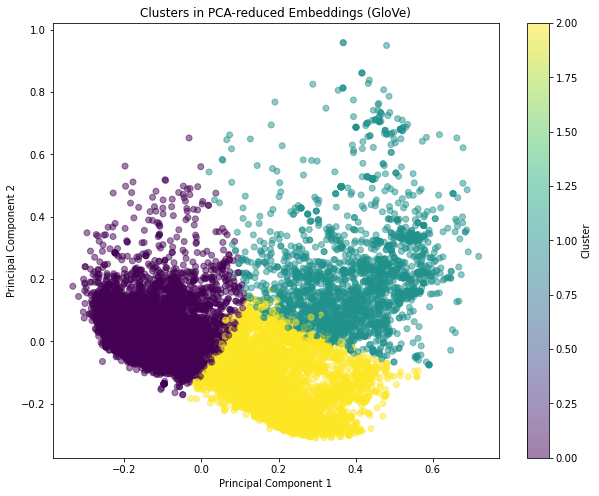

In [ ]:
glove_model = api.load('glove-wiki-gigaword-100')

# Vectorize product descriptions using GloVe embeddings
def get_mean_glove_vector(text):
    words = word_tokenize(text)
    vectors = [glove_model[word] for word in words if word in glove_model]
    return np.mean(vectors, axis=0) if vectors else None

X_glove = df['Product Description'].apply(get_mean_glove_vector)
X_glove = np.vstack(X_glove.dropna())

# Normalize embeddings
normalized_embeddings = X_glove / np.linalg.norm(X_glove, axis=1, keepdims=True)

# Clustering
kmeans_glove = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters_glove = kmeans_glove.fit_predict(normalized_embeddings)

# Visualize by using PCA 
pca_glove = PCA(n_components=3)
compressed_embeddings_glove = pca_glove.fit_transform(normalized_embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(compressed_embeddings_glove[:, 0], compressed_embeddings_glove[:, 1], c=clusters_glove, cmap='viridis', alpha=0.5)
plt.colorbar(label='Cluster')
plt.title('Clusters in PCA-reduced Embeddings (GloVe)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

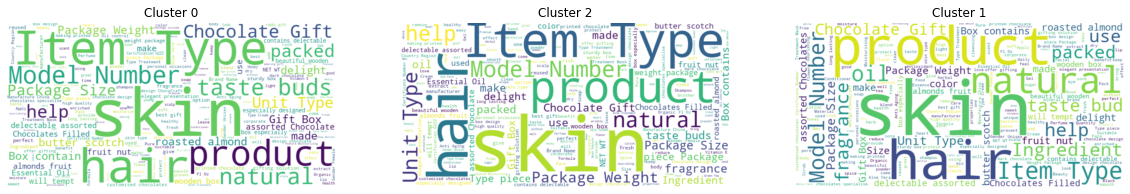

In [ ]:
cluster_texts_glove = defaultdict(str)
for text, label in zip(df['Product Description'], clusters_glove):
    cluster_texts_glove[label] += " " + text

plt.figure(figsize=(20, 10))
for i, (label, text) in enumerate(cluster_texts_glove.items(), 1):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.subplot(1, len(cluster_texts_glove), i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Cluster {label}')
    plt.axis("off")
plt.show()

In [95]:
# Perform PCA on the GloVe vectors
pca_glove = TruncatedSVD(n_components=50, random_state=42)
X_glove_pca = pca_glove.fit_transform(X_glove)

def get_mean_glove_vectors(words):
    vectors = [glove_model[word] for word in words if word in glove_model]
    if len(vectors) == 0:
        return np.zeros(100)  # Return a zero vector of the same dimension as the GloVe vectors
    return np.mean(vectors, axis=0)

# Vectorize the entire dataset using GloVe embeddings
X_glove = np.array([get_mean_glove_vectors(word_tokenize(text)) for text in df['Product Description']])
X_glove = np.nan_to_num(X_glove)  # Handle NaN values

# Perform PCA on the GloVe vectors
pca_glove = TruncatedSVD(n_components=50, random_state=42)
X_glove_pca = pca_glove.fit_transform(X_glove)

# Fit the KNN model on the PCA-transformed GloVe vectors
knn_glove_pca = NearestNeighbors(n_neighbors=15, metric='cosine')
knn_glove_pca.fit(X_glove_pca)

# Define a function to find similar posts using PCA-transformed GloVe vectors
def find_similar_posts_glove_pca(input_text, top_k=15):
    input_vector = get_mean_glove_vectors(word_tokenize(input_text))
    input_vector = input_vector.reshape(1, -1)  # Reshape for compatibility with PCA
    input_pca = pca_glove.transform(input_vector)
    _, indices = knn_glove_pca.kneighbors(input_pca)
    return df.iloc[indices[0]]['Product Title']

# Example usage for PCA-transformed GloVe vectors
input_text = "purple phonecase"
similar_posts_glove_pca = find_similar_posts_glove_pca(input_text)
print("\nSimilar posts using GloVe after PCA:")
print(similar_posts_glove_pca)


Similar posts using GloVe after PCA:
4838      Generic 1Piece Afy Intimate Bleaching Cherry ...
3736      AvonAVON Little Black Dress Eau de Parfum 100...
17223                            Avon Tomorrow EDP - 50ml 
1672      Sinland Makeup Remover Cloth - Chemical Free ...
4031      Generic Private Part Pink Underarm Intimate W...
5135      Generic pink black white, Adult Xlarge : digi...
3484      Generic Intimate Vaginal Lips Private Part Pi...
15599     Branded SLB Works New 50g Tea Blue Butterfly ...
19720           Atomy Sun Cream (SPF50+/PA+++) - #2 Beige 
1250                          Magic In The Air Shower Gel 
14462     Generic orange black white, Adult small : dig...
20081                             Lemon Green Tea 25 Bags 
6556      shrinika Thick absorbent cute rabbit ears dry...
1857      Generic black gray white, Adult small : digit...
769       Stockout HUDA BEAUTY Power Bullet Metallic Li...
Name: Product Title, dtype: object
